# Begin

In [1]:
import os
import pandas as pd
import numpy as np
import argparse
from random import shuffle
import copy 
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
#from torchnet.meter import AverageValueMeter
import torch.backends.cudnn as cudnn

In [4]:
import torch.utils.data as data

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Params

In [6]:
parser = {
    'nb_epoch': 15,
    'test_size': 0.1,
    'learning_rate': 0.001,
    'samples_per_epoch': 64,
    'batch_size': 64,
    'cuda': False,
    'seed': 17122018,
    'dataset_dir': '../data',
    'center': 'C1-6_CanTho',
    'input_type': 'C1',
    'output_dir': 'ANN_2_layers_normal_output/',
    'model_arch': 'ANN_2_layers_normal',
}

args = argparse.Namespace(**parser)
args.cuda = args.cuda and torch.cuda.is_available()
if args.input_type == 'C1':
    args.input_features = 2
elif args.input_type == 'C2':
    args.input_features = 3
elif args.input_type == 'C3':
    args.input_features = 4
elif args.input_type == 'C4':
    args.input_features = 3
elif args.input_type == 'C5':
    args.input_features = 4
else:
    args.input_features = 5 # C6

if args.cuda:
    torch.cuda.manual_seed(args.seed)
else:
    torch.manual_seed(args.seed)

## READ DATA

In [7]:
input_dir = args.dataset_dir + '/'+ args.center + '/' + args.input_type

In [8]:
X_train_df = pd.read_csv(input_dir + '/Training_Input.txt', sep='\t', header=None)
y_train_df = pd.read_csv(input_dir + '/Training_Target.txt', sep='\t', header=None)
X_valid_df = pd.read_csv(input_dir + '/Validation_Input.txt', sep='\t', header=None)
y_valid_df = pd.read_csv(input_dir + '/Validation_target.txt', sep='\t', header=None)
X_test_df = pd.read_csv(input_dir + '/Testing_Input.txt', sep='\t', header=None)
y_test_df = pd.read_csv(input_dir + '/Testing_Target.txt', sep='\t', header=None)

## Min-Max Normalizer

In [9]:
class Normalizer:
    
    def __init__(self):
        pass

    def fit(self, X):
        self.X = X
        self.min = np.min(X)
        self.max = np.max(X)
        
    def transform(self, X):
        X_norm = (X - self.min) / (self.max - self.min)
        return X_norm
    
    def inverve_transform(self, X_norm):
        X = X_norm * (self.max - self.min) + self.min
        return X

In [10]:
def getPreprapredData(X_df, y_df, input_type):
    if input_type in ['C1', 'C2', 'C5']:
        X_rainfall = copy.deepcopy(X_df[0].values)
        X_rainfall = X_rainfall.reshape(X_rainfall.shape[0], 1)

        X_current = copy.deepcopy(X_df).drop(columns=[0]).values

        y = copy.deepcopy(y_df[0].values)
        y = y.reshape(y.shape[0], 1)
        current_stack = np.column_stack((X_current, y))

        rainfall_normalizer = Normalizer()
        current_normalizer = Normalizer()

        rainfall_normalizer.fit(X_rainfall)
        current_normalizer.fit(current_stack)

        X_rainfall = rainfall_normalizer.transform(X_rainfall)
        X_current = current_normalizer.transform(X_current)
        y_normalized = current_normalizer.transform(y)
        X_normalized = np.column_stack((X_rainfall, X_current))
        #X_normalized = X_current
        return X_normalized, y_normalized, current_normalizer
    else:
        X_rainfall = copy.deepcopy(X_df[[0, 1]].values)
        #X_rainfall = X_rainfall.reshape(X_rainfall.shape[0], 1)

        X_current = copy.deepcopy(X_df).drop(columns=[0, 1]).values

        y = copy.deepcopy(y_df[0].values)
        y = y.reshape(y.shape[0], 1)
        current_stack = np.column_stack((X_current, y))

        rainfall_normalizer = Normalizer()
        current_normalizer = Normalizer()

        rainfall_normalizer.fit(X_rainfall)
        current_normalizer.fit(current_stack)

        X_rainfall = rainfall_normalizer.transform(X_rainfall)
        X_current = current_normalizer.transform(X_current)
        y_normalized = current_normalizer.transform(y)
        X_normalized = np.column_stack((X_rainfall, X_current))
        return X_normalized, y_normalized, current_normalizer

## Define Dataset and Model

In [11]:
class WaterDataset(data.Dataset):
    
    def __init__(self, X, y , is_training=True, transform=None):
        self.X = X
        self.y = y
        self.is_training = is_training
        # self.transform = transform


    def __getitem__(self, index):        
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]

In [12]:
# Here we define our model as a class
class ANN_2_layers_residual(nn.Module):

    def __init__(self, input_features=1, batch_size=64, 
                 output_dim=1, center='C1-6_CanTho'):
        super(ANN_2_layers_residual, self).__init__()
        self.input_features = input_features

        self.batch_size = batch_size
        
        self.ann_net = nn.Sequential(
            nn.Linear(input_features, 64),
            nn.ReLU(),
        )
        # Define the output layer
        self.linear = nn.Linear(64 + input_features,
                                output_dim)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, X, cuda=False):
        #X = X.view(X.size(0), 1, X.size(1)) # TODO: check it again
        out = self.ann_net(X)

        out = self.dropout(out)
        #out = out.view(X.size(0), -1)
        # out = out + X[:, :, -1]
        out = torch.cat((out, X.view(X.size(0), -1)), dim=1)
        out = torch.tanh(self.linear(out))
        
        return out

In [13]:
# Here we define our model as a class
class ANN_2_layers_normal(nn.Module):

    def __init__(self, input_features=1, batch_size=64, 
                 output_dim=1, center='C1-6_CanTho'):
        super(ANN_2_layers_normal, self).__init__()
        self.input_features = input_features

        self.batch_size = batch_size
        
        self.ann_net = nn.Sequential(
            nn.Linear(input_features, 64),
            nn.ReLU(),
        )
        # Define the output layer
        self.linear = nn.Linear(64,
                                output_dim)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, X, cuda=False):
        #X = X.view(X.size(0), 1, X.size(1)) # TODO: check it again
        out = self.ann_net(X)

        out = self.dropout(out)
        #out = out.view(X.size(0), -1)
        # out = out + X[:, :, -1]
        #out = torch.cat((out, X.view(X.size(0), -1)), dim=1)
        out = torch.tanh(self.linear(out))
        
        return out

In [14]:
# Here we define our model as a class
class TwoLayerUsualCNN_C1(nn.Module):

    def __init__(self, input_channel=1, layer1_out=32, layer2_out=64, batch_size=64, length_of_signal=2, kernel_size=2,
                    output_dim=1):
        super(TwoLayerUsualCNN_C1, self).__init__()
        self.input_channel = input_channel

        self.batch_size = batch_size
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(input_channel, layer1_out, kernel_size=kernel_size, stride=2),
            nn.BatchNorm1d(layer1_out),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=kernel_size, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(layer1_out, layer2_out, kernel_size=kernel_size, stride=2),
            nn.BatchNorm1d(layer2_out),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=kernel_size, stride=2))
        self.dropout = nn.Dropout(p=0.4)

        # Define the output layer
        self.linear = nn.Linear(layer2_out + length_of_signal,
                                output_dim)

    def forward(self, X, cuda=False):
        X = X.view(X.size(0), 1, X.size(1)) # TODO: check it again
        out = self.layer1(X)
        out = self.layer2(out)

        out = self.dropout(out)
        out = out.view(X.size(0), -1)
        # out = out + X[:, :, -1]
        out = torch.cat((out, X.view(X.size(0), -1)), dim=1)
        out = torch.tanh(self.linear(out))
        return out

## Define Train valid

In [15]:
# Training
def train(epoch, net, dataloader, optimizer, criterion, use_cuda):
    net.train()
    train_loss = 0
    
    for batch_idx, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        #X = X.view(1, X.size(0), 2)
        #X = X.view(X.size(0), 1, X.size(1))
        X, y = Variable(X.float()), Variable(y.float())
        if use_cuda:
            X, y = X.cuda(), y.cuda()
        out = net(X)
        loss = criterion(out, y.view(y.size(0), 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        if batch_idx % 100 == 0:
            print('Train Loss: %.3f '
                % (train_loss/((batch_idx+1)*3)))

In [16]:
# Test
def test(net, dataloader, criterion, use_cuda):
    net.eval()
    test_loss = 0
    y_pred = []
    for batch_idx, (X, y) in enumerate(dataloader):
        #X = X.view(1, X.size(0), 2)
        #X = X.view(X.size(0), 1, X.size(1))
        X, y = Variable(X.float()), Variable(y.float())
        if use_cuda:
            X, y = X.cuda(), y.cuda()
        out = net(X)
        loss = criterion(out, y.view(y.size(0), 1))
        test_loss += loss.data.item()
        y_pred.extend(out.view(-1).detach().numpy())
            
    #print('Test Loss: %.3f ' % (test_loss/((batch_idx+1)*3)))
    return np.array(y_pred)

## Set up training

In [17]:
X_train_normalized, y_train_normalized, train_current_normalizer = getPreprapredData(X_train_df, 
                                                           y_train_df, args.input_type)
X_valid_normalized, y_valid_normalized, valid_current_normalizer = getPreprapredData(X_valid_df, 
                                                           y_valid_df, args.input_type)
X_test_normalized, y_test_normalized, test_current_normalizer = getPreprapredData(X_test_df, 
                                                         y_test_df, args.input_type)

In [18]:
if args.center == 'C1-6_ChauDoc':
    X_test_normalized[428:429, 0] = 0.02741021  # Chau Doc
else:
    X_test_normalized[397:398, 0] = 0 # Can Tho


In [19]:
train_dataset = WaterDataset(X_train_normalized, y_train_normalized)
valid_dataset = WaterDataset(X_valid_normalized, y_valid_normalized)
test_dataset = WaterDataset(X_test_normalized, y_test_normalized)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

In [21]:

#net = ANN(input_features=args.input_features, batch_size=64)
if args.model_arch == 'ANN_2_layers_normal':
    net = ANN_2_layers_normal(input_features=args.input_features, batch_size=64)
elif args.model_arch == 'ANN_2_layers_residual':
    net = ANN_2_layers_residual(input_features=args.input_features, batch_size=64)
#net = TwoLayerCNN_TwoFC(1, layer1_cnn_out=32, layer2_cnn_out=64, layer1_fc_out=64, batch_size=args.batch_size, length_of_signal=args.length_of_signal)
optimizer = optim.Adam(net.parameters(), lr=0.1)
#optimizer = optim.Adadelta(net.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=1e-05)
#optimizer = optim.Adadelta(net.parameters(), lr=0.1, rho=0.9, eps=1e-06)
#optimizer = optim.Adagrad(net.parameters(), lr=0.01, lr_decay=1e-05, weight_decay=1e-05, initial_accumulator_value=0)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0)
#optimizer = optim.Adamax(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

if args.cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

criterion = nn.MSELoss()
epoch_count = 0

In [22]:
#checkpoint = torch.load('TwoLayerUsualCNN_32_64_C1-6_CanTho_C5.pkl')
#checkpoint = torch.load('TwoLayerUsualCNN_16_32_C1-6_ChauDoc_C2.pkl')
#net.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [23]:
for epoch in range(0, 15):
    epoch_count += 1
    #optimizer = lr_scheduler(optimizer, epoch, lr_decay_epoch=args.lr_decay_epoch)	
    print('\nEpoch: %d' % epoch_count)
    train(epoch, net, train_loader, optimizer, criterion, args.cuda)
    #valid(epoch, net, valid_loader, criterion, args.cuda)
    
    y_pred_train = test(net, train_loader, criterion, args.cuda)
    y_pred_train_unnormalized = train_current_normalizer.inverve_transform(y_pred_train)
    train_rmse = math.sqrt(mean_squared_error(y_train_df[0].values, y_pred_train_unnormalized))
    
    y_pred_valid = test(net, valid_loader, criterion, args.cuda)
    y_pred_valid_unnormalized = valid_current_normalizer.inverve_transform(y_pred_valid)
    valid_rmse = math.sqrt(mean_squared_error(y_valid_df[0].values, y_pred_valid_unnormalized))
    
    print('Train RMSE: %.3f -- Valid RMSE: %.3f ' % (train_rmse, valid_rmse))


Epoch: 1
Train Loss: 0.007 
Train RMSE: 4837.096 -- Valid RMSE: 5989.345 

Epoch: 2
Train Loss: 0.002 
Train RMSE: 3440.545 -- Valid RMSE: 4109.202 

Epoch: 3
Train Loss: 0.001 
Train RMSE: 2838.470 -- Valid RMSE: 2919.596 

Epoch: 4
Train Loss: 0.001 
Train RMSE: 2674.237 -- Valid RMSE: 2822.370 

Epoch: 5
Train Loss: 0.001 
Train RMSE: 2847.222 -- Valid RMSE: 3165.176 

Epoch: 6
Train Loss: 0.000 
Train RMSE: 2876.013 -- Valid RMSE: 3162.433 

Epoch: 7
Train Loss: 0.001 
Train RMSE: 2768.466 -- Valid RMSE: 3132.270 

Epoch: 8
Train Loss: 0.000 
Train RMSE: 2956.461 -- Valid RMSE: 3211.817 

Epoch: 9
Train Loss: 0.000 
Train RMSE: 3089.594 -- Valid RMSE: 3315.897 

Epoch: 10
Train Loss: 0.001 
Train RMSE: 2900.998 -- Valid RMSE: 3182.770 

Epoch: 11
Train Loss: 0.001 
Train RMSE: 2791.490 -- Valid RMSE: 2877.670 

Epoch: 12
Train Loss: 0.001 
Train RMSE: 2995.821 -- Valid RMSE: 3284.231 

Epoch: 13
Train Loss: 0.001 
Train RMSE: 2992.023 -- Valid RMSE: 3155.316 

Epoch: 14
Train Loss

## Change Lr

In [ ]:
for param in optimizer.param_groups:
    print(param['lr'])

In [ ]:
optimizer_copy = copy.deepcopy(optimizer)
for param in optimizer_copy.param_groups:
    param['lr'] = 0.1

In [ ]:
net_copy = TwoLayerUsualCNN(input_channel=1, 
                       layer1_out=32, 
                       layer2_out=64, 
                       batch_size=args.batch_size, 
                       length_of_signal=args.length_of_signal)
net_copy.load_state_dict(net.state_dict())

In [ ]:
for epoch in range(0, 3):
    epoch_count += 1
    #optimizer = lr_scheduler(optimizer, epoch, lr_decay_epoch=args.lr_decay_epoch)	
    print('\nEpoch: %d' % epoch_count)
    train(epoch, net_copy, train_loader, optimizer_copy, criterion, args.cuda)
    #valid(epoch, net, valid_loader, criterion, args.cuda)
    
    y_pred_train = test(net_copy, train_loader, criterion, args.cuda)
    y_pred_train_unnormalized = train_current_normalizer.inverve_transform(y_pred_train)
    train_rmse = math.sqrt(mean_squared_error(y_train_df[0].values, y_pred_train_unnormalized))
    
    y_pred_valid = test(net_copy, valid_loader, criterion, args.cuda)
    y_pred_valid_unnormalized = valid_current_normalizer.inverve_transform(y_pred_valid)
    valid_rmse = math.sqrt(mean_squared_error(y_valid_df[0].values, y_pred_valid_unnormalized))
    
    print('Train RMSE: %.3f -- Valid RMSE: %.3f ' % (train_rmse, valid_rmse))

## Metrics

In [24]:
# Test RMSE
y_pred = test(net, test_loader, criterion, args.cuda)
y_pred_unnormalized = test_current_normalizer.inverve_transform(y_pred)
rmse = math.sqrt(mean_squared_error(y_test_df[0].values, y_pred_unnormalized))
r2Score = r2_score(y_test_df[0].values, y_pred_unnormalized)
mae = mean_absolute_error(y_test_df[0].values, y_pred_unnormalized)
print('R2: %.3f -- RMSE: %.3f -- MAE: %.3f' % (r2Score, rmse, mae))

R2: 0.700 -- RMSE: 3056.271 -- MAE: 2379.031


In [25]:
y_pred_df = pd.DataFrame(y_pred_unnormalized)
y_pred_df['index'] = y_pred_df.index
y_test_df['index'] = y_test_df.index
y_pred_df.head()

,0,index
0,2601.99585,0
1,2601.99585,1
2,2601.99585,2
3,2601.99585,3
4,2601.99585,4


In [26]:
plt.rcParams['figure.figsize'] = [8, 6] # Discharge vs Time
#plt.rcParams['figure.figsize'] = [6, 6] # Predicted vs Observed

In [27]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


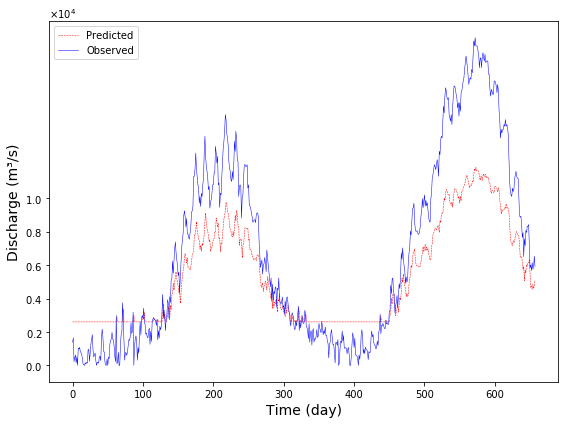

In [28]:
# Draw discharge vs time
x = list(range(len(y_pred_unnormalized)))
plt.plot(x, y_pred_unnormalized, label='Predicted', color='red', linestyle='dashed', linewidth=0.5)
plt.plot(x, y_test_df[0].values, label='Observed', color='blue', linewidth=0.5)
plt.legend(loc='upper left')
#plt.title('CNN Model - Test vs Prediction', fontdict={'fontsize': 18})
plt.xlabel('Time (day)', fontdict={'fontsize': 14})
plt.ylabel('Discharge (m\u00b3/s)', fontdict={'fontsize': 14})
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
plt.yticks([0, 2000, 4000, 6000, 8000, 10000]) #Chau Doc
#plt.yticks([0, 5000, 10000, 15000, 20000]) #Can Tho
image_file_name = '{}_{}_{}.jpg'.format(args.model_arch, args.center, args.input_type)
#plt.savefig(image_file_name, dpi=400)
plt.show()

IndexError: tuple index out of range

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


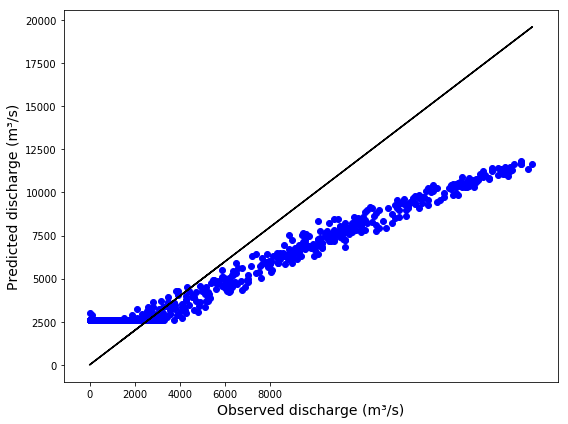

In [30]:
# Draw predicted and observed discharge
x = list(range(len(y_pred_unnormalized)))
plt.plot(y_test_df[0].values,y_test_df[0].values, color='black')
plt.scatter(y_test_df[0].values, y_pred_unnormalized, label='Predicted', color='blue', )
#plt.legend(loc='upper left')
#plt.title('CNN Model - Test vs Prediction', fontdict={'fontsize': 18})
plt.xlabel('Observed discharge (m\u00b3/s)', fontdict={'fontsize': 14})
plt.ylabel('Predicted discharge (m\u00b3/s)', fontdict={'fontsize': 14})
plt.xticks([0, 2000, 4000, 6000, 8000]) # Chau Doc
#plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
#plt.xticks([0, 5000, 10000, 15000, 20000]) #Can Tho
#plt.yticks([0, 5000, 10000, 15000, 20000]) #Can Tho
image_file_name_2 = '{}_{}_{}_{}_{}_predicted_vs_observed.jpg'.format(args.model_arch, args.center, args.input_type)
#plt.savefig(image_file_name_2, dpi=400)
plt.show()

## Save Checkpoint

In [ ]:
checkpoint = {
            'center': args.center,
            'input_type': args.input_type,
            'model_arch': args.model_arch,
            'optimizer_arch': 'optim.Adam(net.parameters(), lr=0.01)',
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'valid_rmse': valid_rmse,
            }

In [ ]:
filename = '{}_{}_{}.pkl'.format(args.model_arch, args.center, args.input_type)
filename

In [ ]:
torch.save(checkpoint, filename)

## Load Old Model

In [ ]:
checkpoint = torch.load('./ANN_normal_2th_C1-6_CanTho_C1.pkl')

In [ ]:
net.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# Test RMSE
y_pred = test(net_loaded, test_loader, criterion, args.cuda)
y_pred_unnormalized = test_current_normalizer.inverve_transform(y_pred)
rmse = math.sqrt(mean_squared_error(y_test_df[0].values, y_pred_unnormalized))
r2_score = r2_score(y_test_df[0].values, y_pred_unnormalized)
mae = mean_absolute_error(y_test_df[0].values, y_pred_unnormalized)
print('RMSE: %.3f -- R2_score: %.3f -- MAE: %.3f' % (rmse, r2_score, mae))

In [ ]:
X_test_normalized[390:400]

In [ ]:
plt.plot(y_pred_unnormalized, label='y_pred', color='blue')
plt.plot(y_test_df[0].values, label='y_test', color='orange')
plt.legend(loc='lower left')
plt.title('CNN Model - Test vs Prediction')